In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"



import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())



[cuda(id=0)]
gpu
[cuda(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [2]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    0,
    6907,
    [
        Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-6907-3.npz", 
    ],
    clean=True
)


R (6907, 60, 3)
Z (6907, 60)
N (6907,)
D (6907,)
com (6907, 3)
Dxyz (6907, 3)
mono (6907, 60, 1)
esp (6907, 3200)
id (6907,)
n_grid (6907,)
vdw_surface (6907, 3200, 3)
n_failed: 286
0 6621
creating_mask
6621


In [3]:
valid_batches = prepare_batches(data_key, valid_data, 1, include_id=True)

In [5]:
len(valid_data["Z"])

6621

In [17]:
N = 100
random_ids = [random.randint(0, len(valid_batches)) for _ in range(N)]

In [122]:
for _ in list((ddir / "vdwr14").glob("*/best*pkl")):
    print("restart="+str(_))
    print("sbatch --export=restart=$restart restart.sh")
    print()

restart=/pchem-data/meuwly/boittier/home/jaxeq/all_runs/vdwr14/20240926-104221dcm-2-espw-1000.0-restart-True/best_1000.0_params.pkl
sbatch --export=restart=$restart restart.sh

restart=/pchem-data/meuwly/boittier/home/jaxeq/all_runs/vdwr14/20240926-104750dcm-2-espw-1000.0-restart-True/best_1000.0_params.pkl
sbatch --export=restart=$restart restart.sh

restart=/pchem-data/meuwly/boittier/home/jaxeq/all_runs/vdwr14/20240926-104809dcm-4-espw-1000.0-restart-True/best_1000.0_params.pkl
sbatch --export=restart=$restart restart.sh

restart=/pchem-data/meuwly/boittier/home/jaxeq/all_runs/vdwr14/20240926-104833dcm-4-espw-1000.0-restart-True/best_1000.0_params.pkl
sbatch --export=restart=$restart restart.sh

restart=/pchem-data/meuwly/boittier/home/jaxeq/all_runs/vdwr14/20240926-104940dcm-3-espw-1000.0-restart-True/best_1000.0_params.pkl
sbatch --export=restart=$restart restart.sh

restart=/pchem-data/meuwly/boittier/home/jaxeq/all_runs/vdwr14/20240926-104940dcm-2-espw-1000.0-restart-True/best_1

In [108]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")
# p = ddir / "runs10/20240923-175645dcm-4-espw-10000.0-restart-False/best_10000.0_params.pkl"


p = ddir / "runs11/20240924-141337dcm-2-espw-1000.0-restart-False/best_1000.0_params.pkl"
model, params = create_model_and_params(p)
# p = ddir / "tests/20240925-150643dcm-2-espw-1000.0-restart-True/best_1000.0_params.pkl"
# p = ddir / "tests/20240925-143444dcm-2-espw-1000.0-restart-True/best_1000.0_params.pkl"
# p = ddir / "runs11/20240924-141632dcm-2-espw-1000.0-restart-False/best_1000.0_params.pkl"
# p = ddir / "vdwr14/20240926-104221dcm-2-espw-1000.0-restart-True/best_1000.0_params.pkl"
# p = ddir / "vdwr14/20240926-104750dcm-2-espw-1000.0-restart-True/best_1000.0_params.pkl"
# p = ddir / "vdwr14/20240926-104940dcm-2-espw-1000.0-restart-True/best_1000.0_params.pkl"
# p = ddir / "vdwr14/20240926-105208dcm-3-espw-1000.0-restart-True/best_1000.0_params.pkl"
# p = ddir / "vdwr14/20240926-110708dcm-3-espw-1000.0-restart-True/best_1000.0_params.pkl"
# p = ddir / "vdwr14/20240926-104940dcm-3-espw-1000.0-restart-True/best_1000.0_params.pkl"
# p = ddir / "vdwr14/20240926-105148dcm-4-espw-1000.0-restart-True/best_1000.0_params.pkl"
# p = ddir / "vdwr14/20240926-104833dcm-4-espw-1000.0-restart-True/best_1000.0_params.pkl"
# p = ddir / "vdwr14/20240926-104809dcm-4-espw-1000.0-restart-True/best_1000.0_params.pkl"

# p = ddir / "runs888/20240925-181850dcm-3-espw-1000.0-restart-True/best_1000.0_params.pkl"
# p = ddir / "runs888/20240925-181429dcm-4-espw-1000.0-restart-True/best_1000.0_params.pkl"
# p = ddir / "runs11/20240924-142115dcm-3-espw-1000.0-restart-False/best_1000.0_params.pkl"
# p = ddir / "runs11/20240924-141426dcm-3-espw-1000.0-restart-False/best_1000.0_params.pkl"

# p = ddir / "runs11/20240924-142048dcm-4-espw-1000.0-restart-False/best_1000.0_params.pkl"
# p = ddir / "runs11/20240924-142048dcm-4-espw-1000.0-restart-False/best_1000.0_params.pkl"
print(p)
model, params = create_model_and_params(p)
model

{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 2.0, 'include_pseudotensors': True}
/pchem-data/meuwly/boittier/home/jaxeq/all_runs/vdwr14/20240926-104750dcm-2-espw-1000.0-restart-True/best_1000.0_params.pkl
{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 2.0, 'include_pseudotensors': False}


MessagePassingModel(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 2
    include_pseudotensors = False
)

In [109]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(random_ids):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=False,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


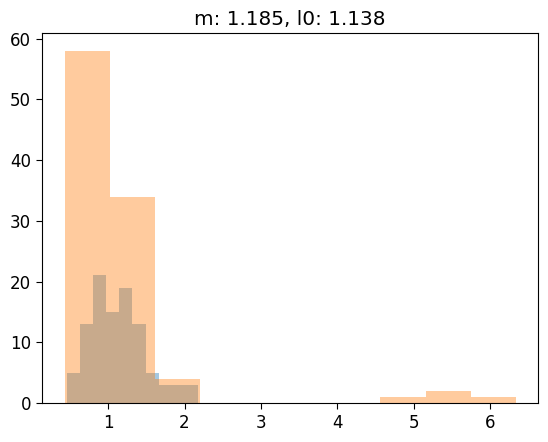

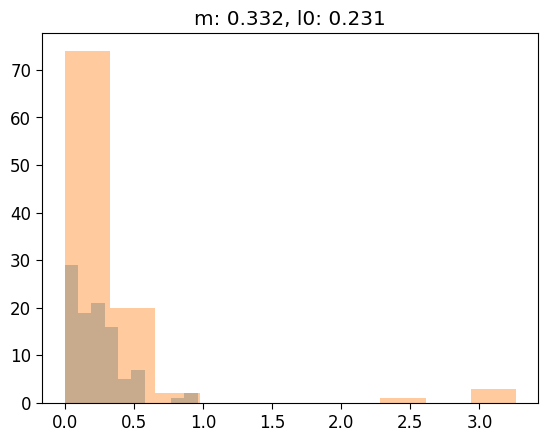

In [110]:
m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()

In [111]:
df_ = pd.DataFrame({"i": indexes, "m": m.flatten(), "l0": l0.flatten(), "dm": dm, "dl0": dl0})
df_["dif"] = df_["m"] - df_["l0"]
df_["difd"] = df_["dm"] - df_["dl0"]
df_.describe()

i           m          l0          dm         dl0  \
count   100.000000  100.000000  100.000000  100.000000  100.000000   
mean   3327.290000    1.184675    1.137657    0.332015    0.231150   
std    1863.524115    0.951456    0.364668    0.580015    0.185812   
min     129.000000    0.432715    0.462168    0.001759    0.002396   
25%    1686.500000    0.823265    0.900691    0.082328    0.084987   
50%    3350.000000    0.955234    1.076107    0.177297    0.216055   
75%    4912.500000    1.157115    1.340948    0.335475    0.323738   
max    6487.000000    6.335746    2.174565    3.262330    0.963064   

              dif        difd  
count  100.000000  100.000000  
mean     0.047019    0.100865  
std      1.017300    0.600481  
min     -0.705942   -0.754893  
25%     -0.351579   -0.163493  
50%     -0.168250    0.026035  
75%      0.036639    0.150967  
max      5.376628    3.014592

In [112]:
good = list(df_[df_["dif"] < 0 ].sort_values("dif", ascending=True)["i"])
print(len(good))
df_[df_["dif"] < 0].describe() #.sort_values("dif", ascending=True)

71


i          m         l0         dm        dl0        dif  \
count    71.000000  71.000000  71.000000  71.000000  71.000000  71.000000   
mean   3393.295775   0.961460   1.259387   0.177999   0.251649  -0.297926   
std    1822.989816   0.296320   0.344723   0.144465   0.205816   0.188328   
min     129.000000   0.432715   0.642513   0.001759   0.002396  -0.705942   
25%    2062.000000   0.781834   1.011447   0.060571   0.084347  -0.425467   
50%    3415.000000   0.915180   1.262648   0.135838   0.226115  -0.289609   
75%    4878.000000   1.065457   1.411793   0.279272   0.363596  -0.153297   
max    6420.000000   2.070364   2.174565   0.702413   0.963064  -0.005426   

            difd  
count  71.000000  
mean   -0.073650  
std     0.213090  
min    -0.754893  
25%    -0.206503  
50%    -0.038697  
75%     0.091053  
max     0.301885

  0%|                                                                                                       | 0/10 [00:00<?, ?it/s]

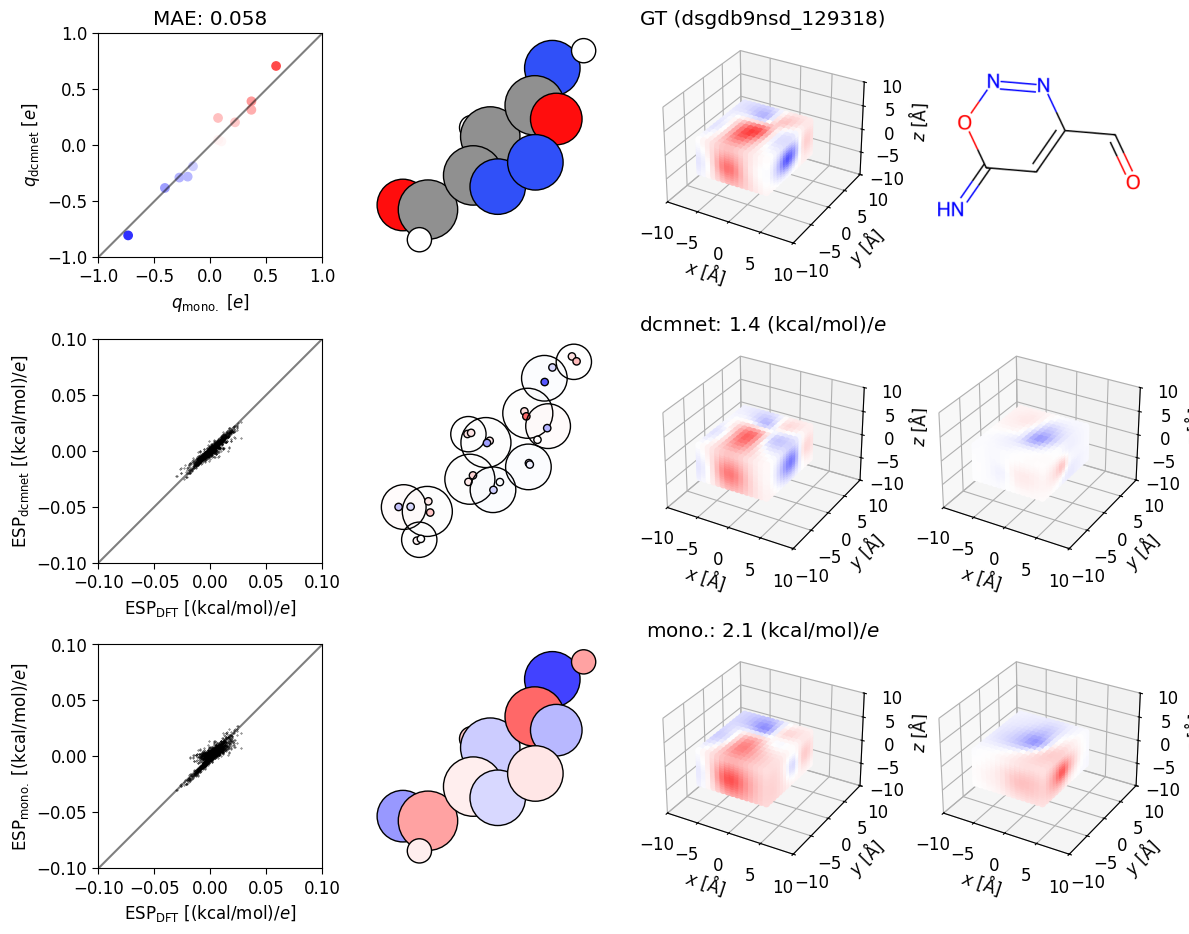

 10%|█████████▌                                                                                     | 1/10 [00:09<01:21,  9.03s/it]

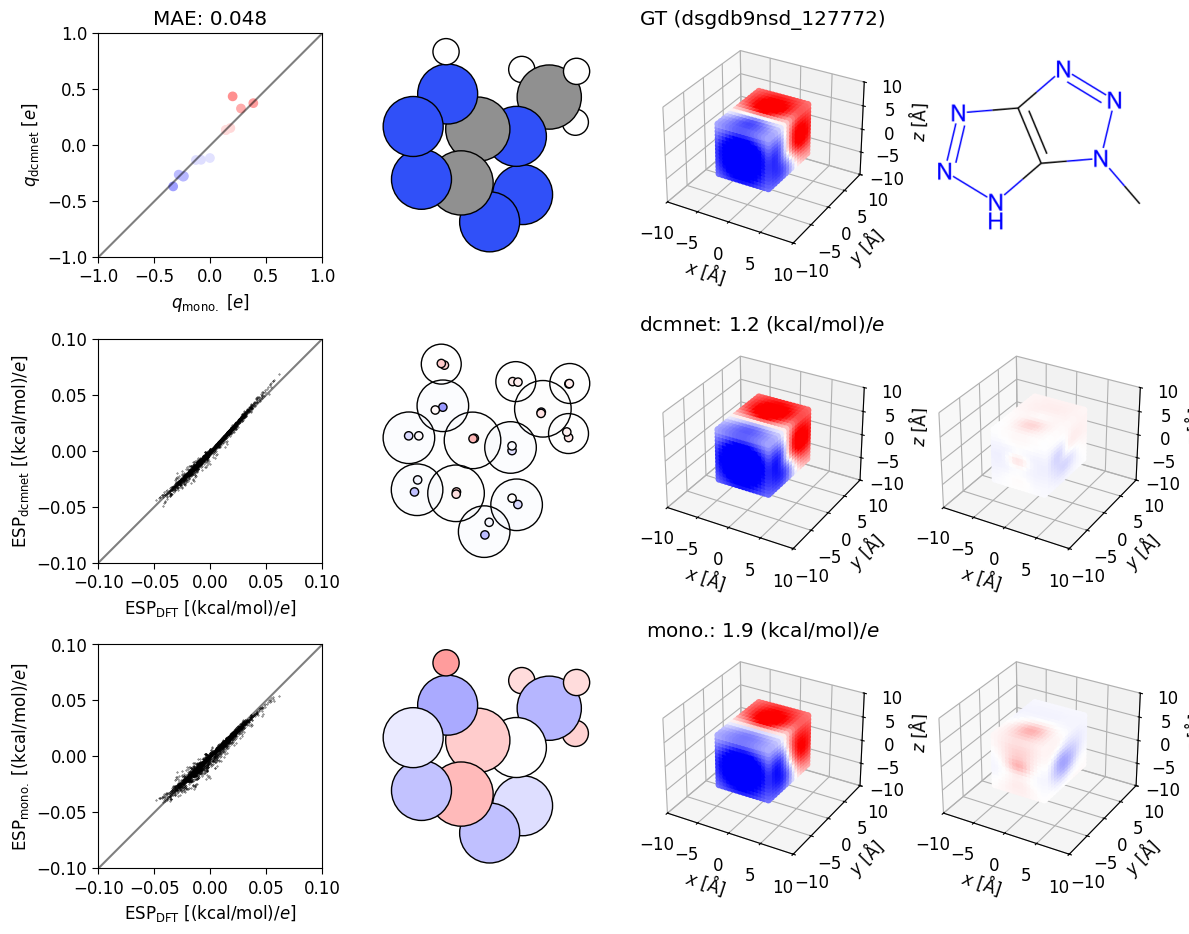

 20%|███████████████████                                                                            | 2/10 [00:18<01:11,  9.00s/it]

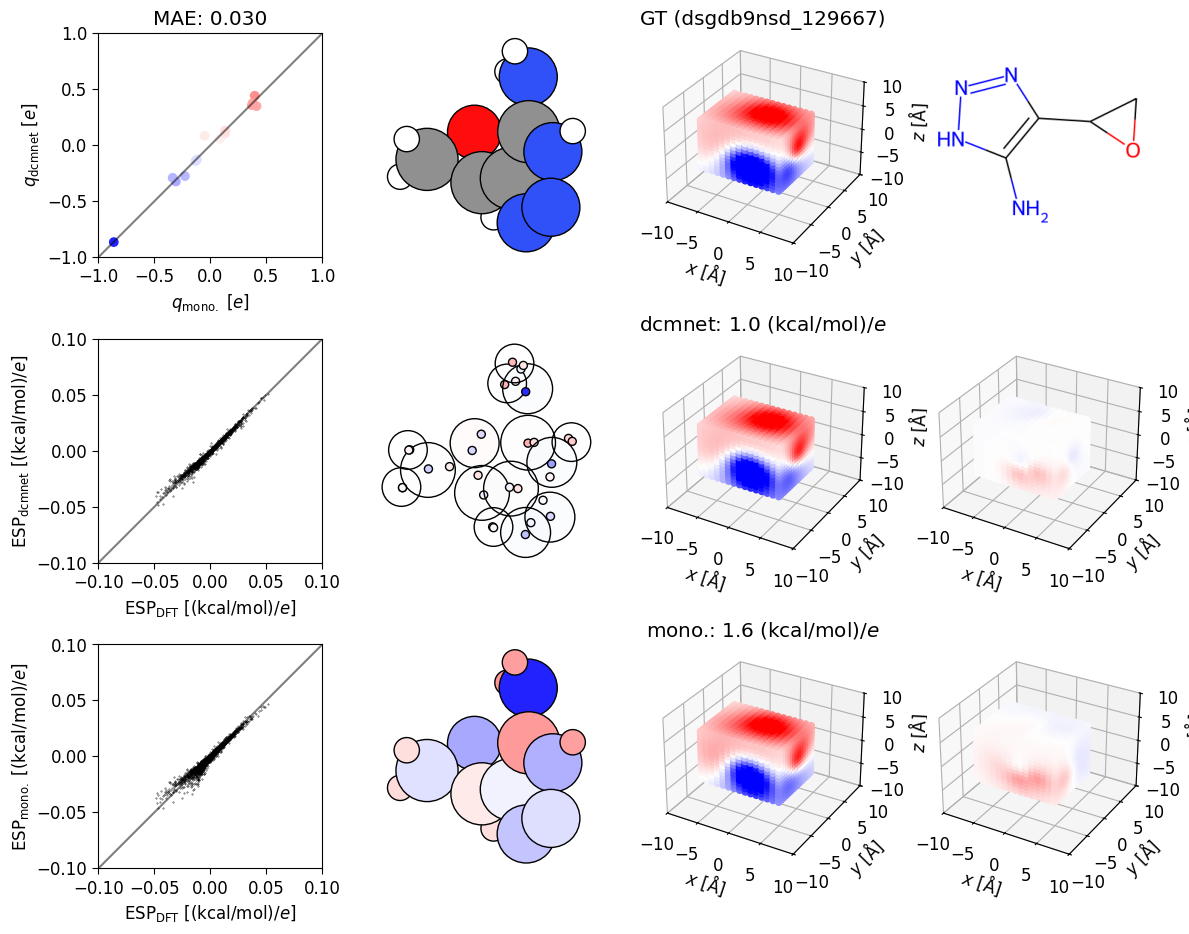

 30%|████████████████████████████▌                                                                  | 3/10 [00:27<01:04,  9.25s/it]

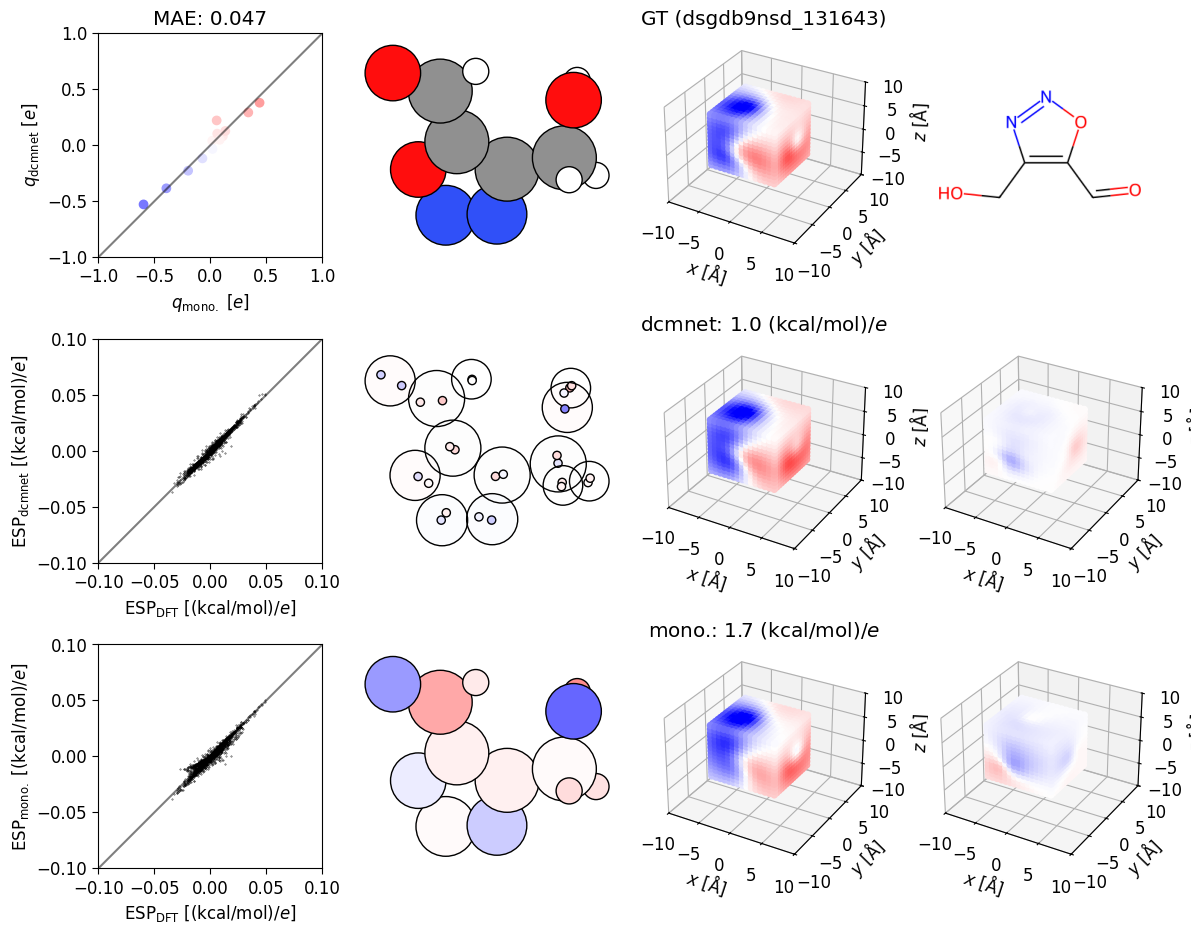

 40%|██████████████████████████████████████                                                         | 4/10 [00:36<00:54,  9.13s/it]

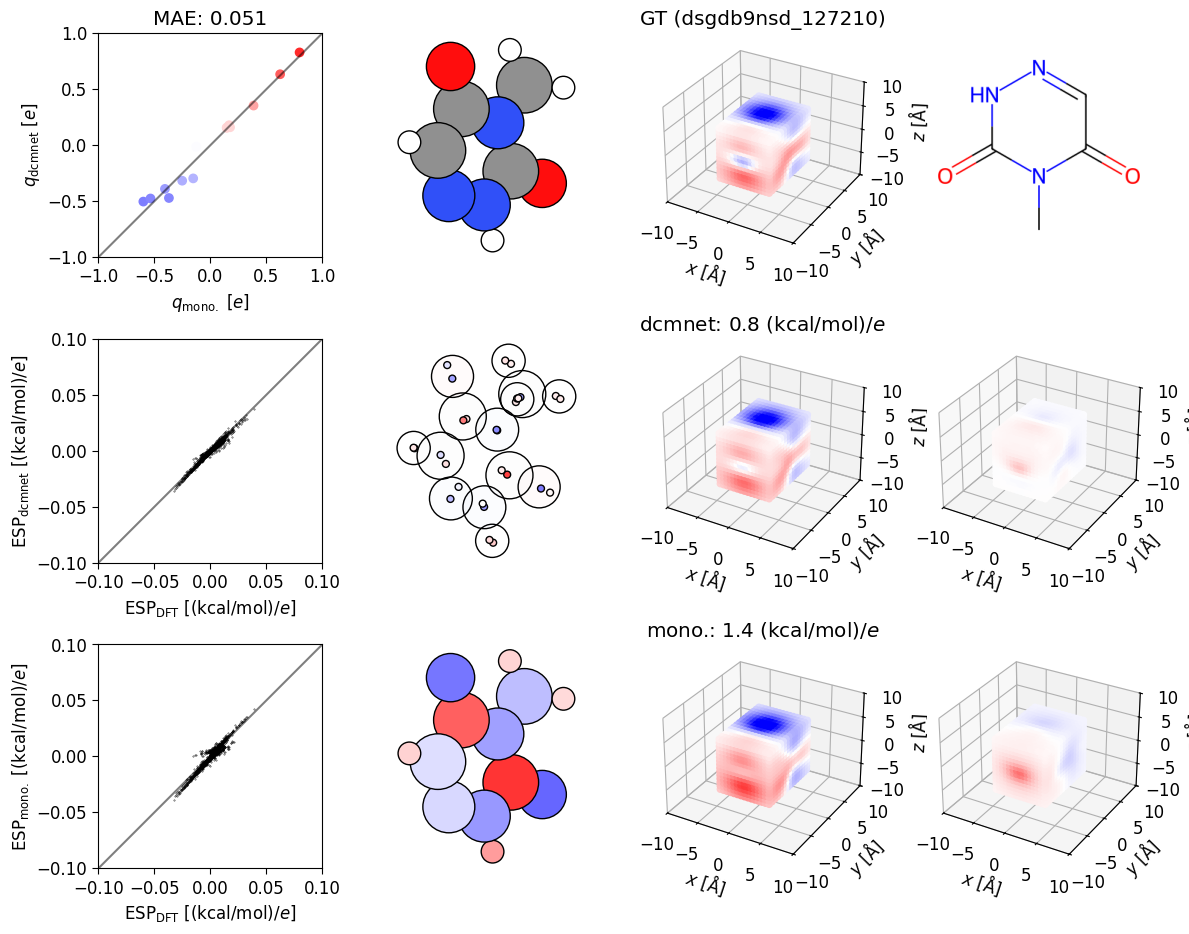

 50%|███████████████████████████████████████████████▌                                               | 5/10 [00:45<00:45,  9.03s/it]

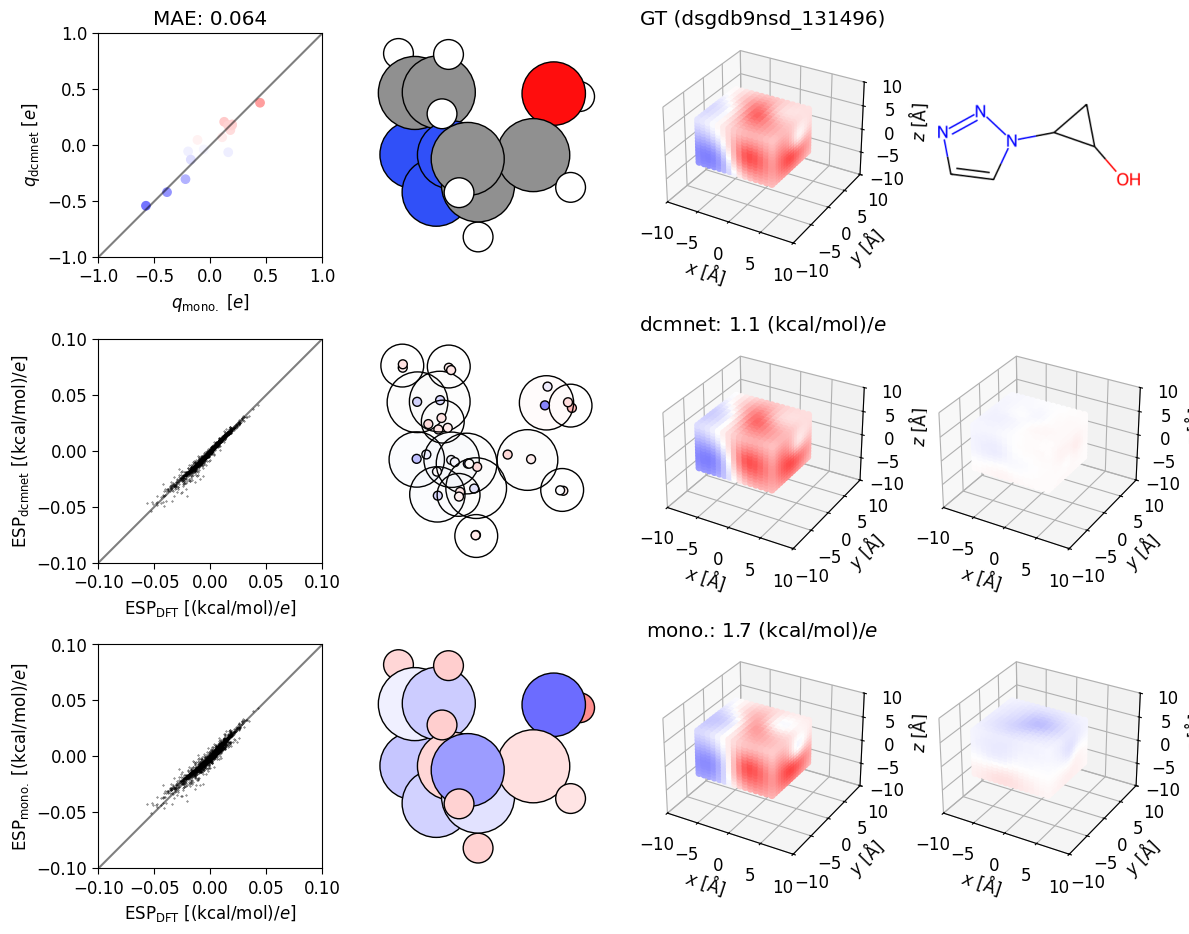

 60%|█████████████████████████████████████████████████████████                                      | 6/10 [00:54<00:36,  9.19s/it]

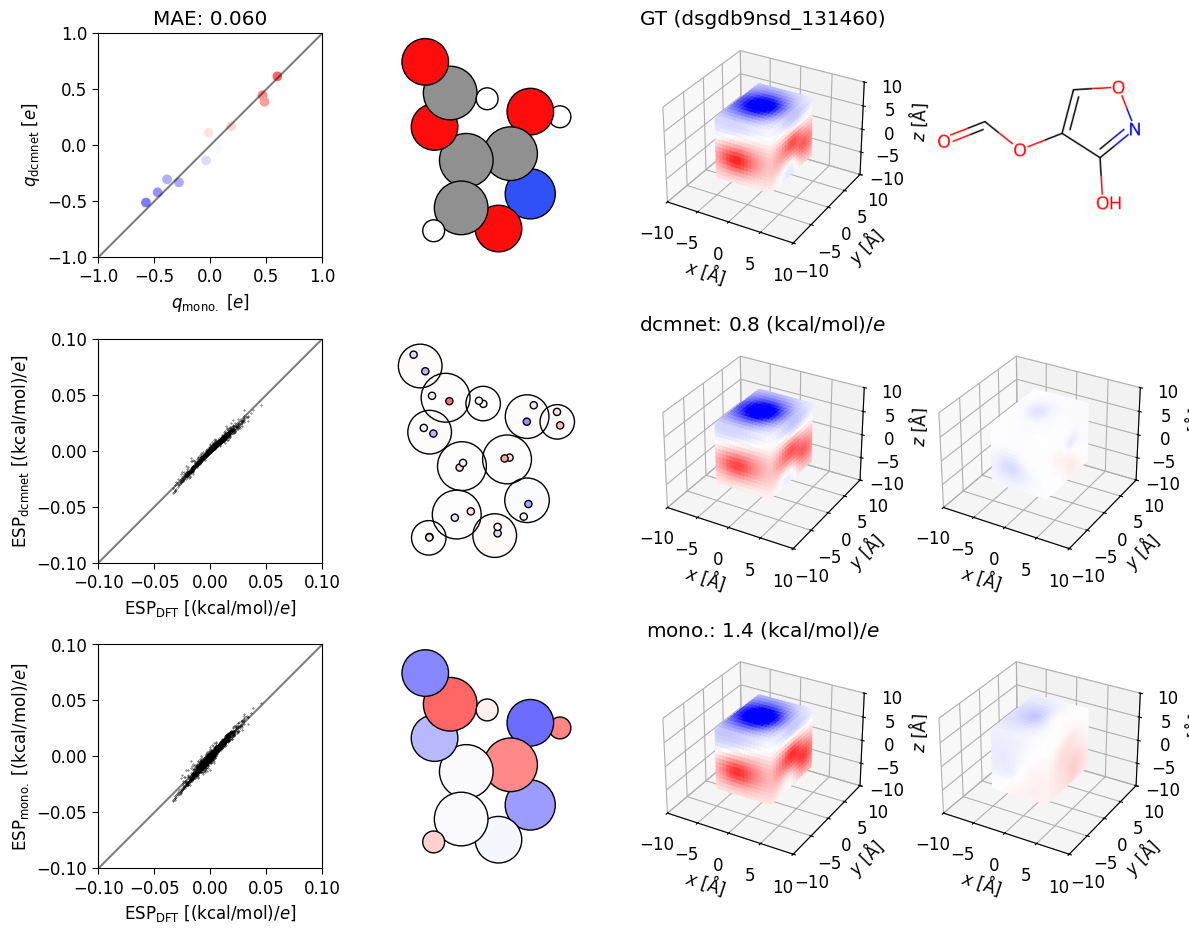

 70%|██████████████████████████████████████████████████████████████████▌                            | 7/10 [01:03<00:27,  9.10s/it]

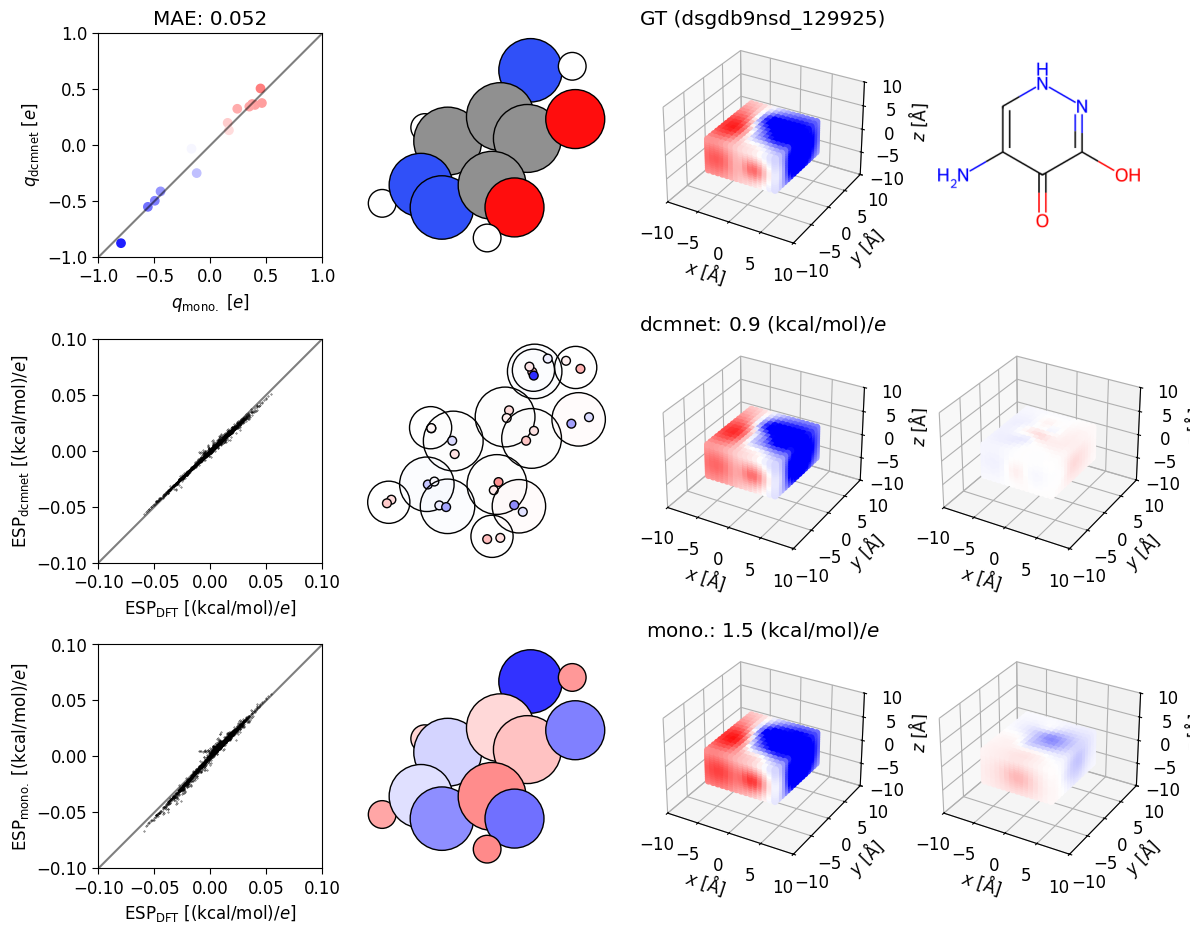

 80%|████████████████████████████████████████████████████████████████████████████                   | 8/10 [01:12<00:18,  9.01s/it]

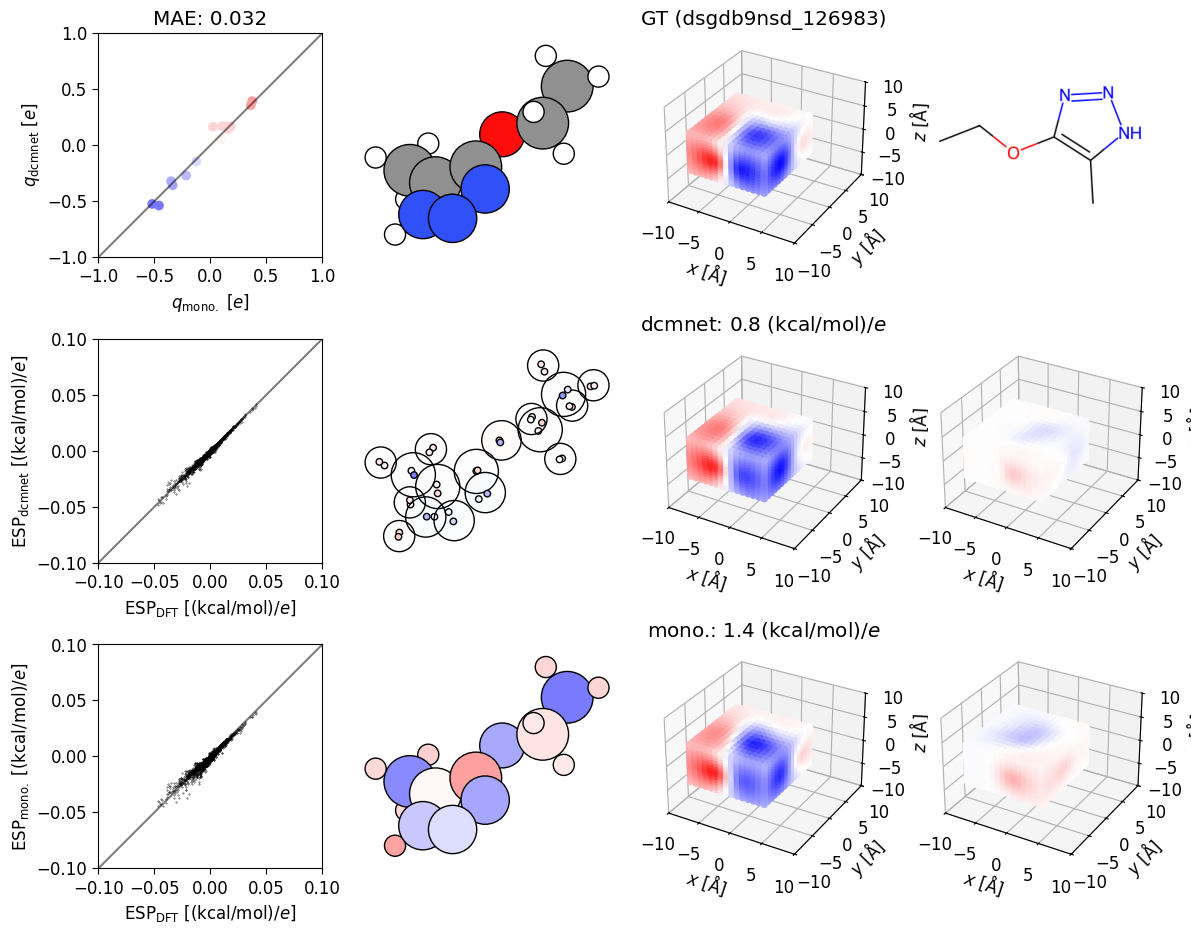

 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 9/10 [01:22<00:09,  9.23s/it]

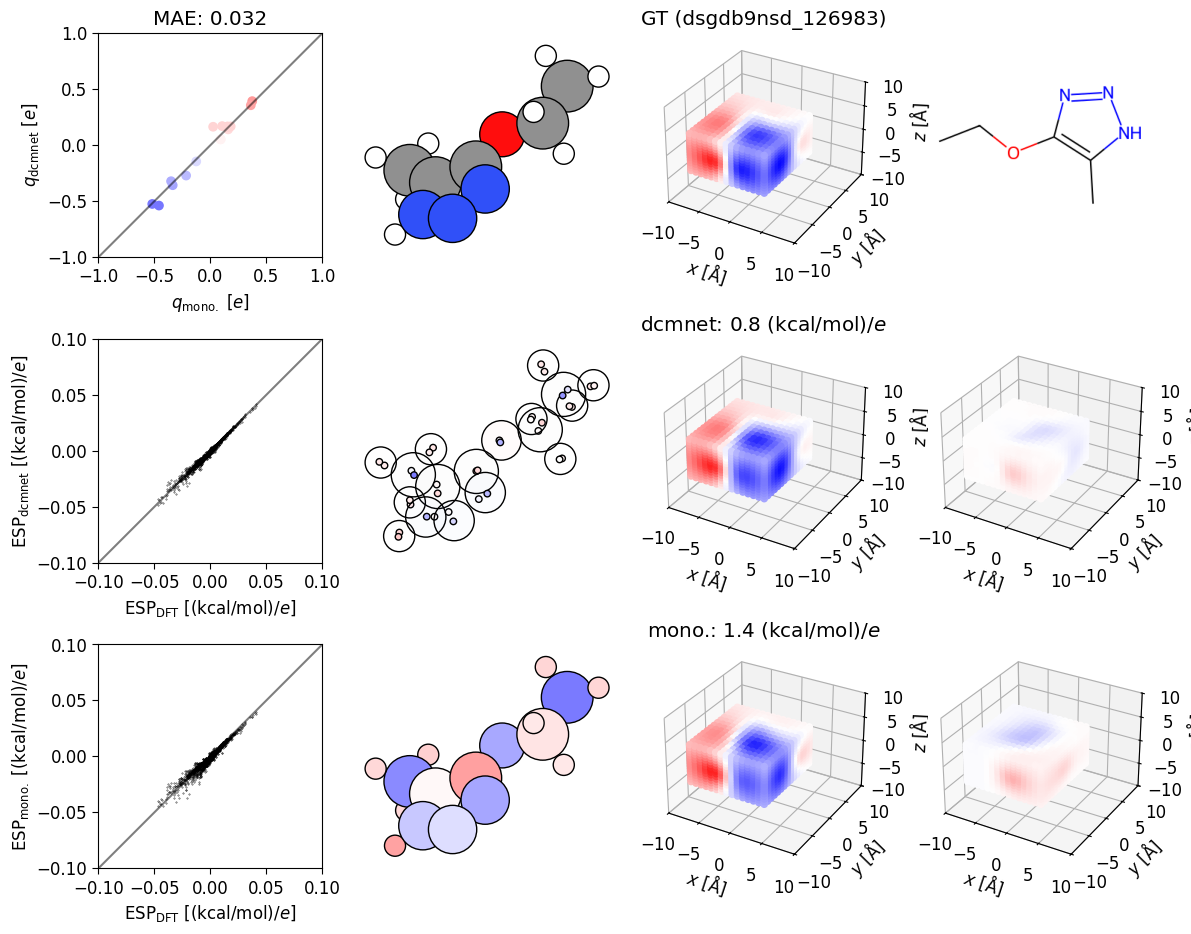

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:31<00:00,  9.17s/it]


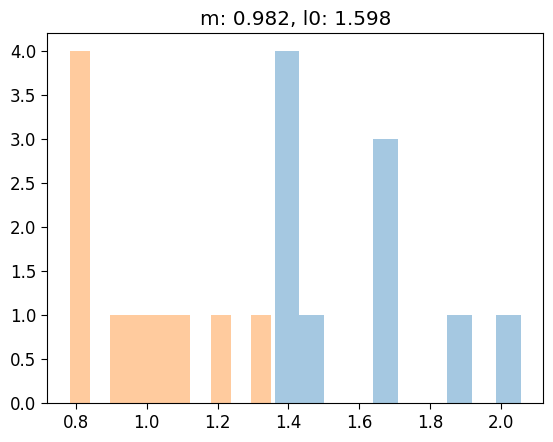

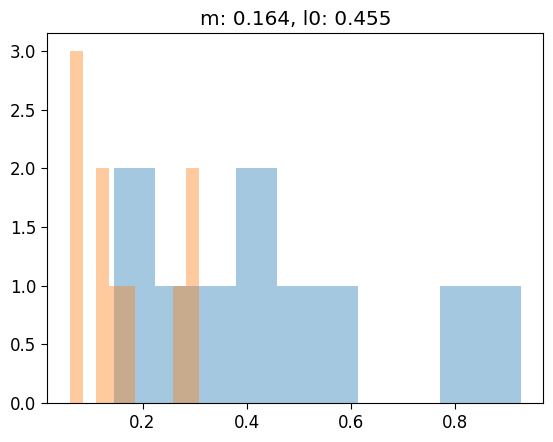

In [113]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(good[:10]):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=True,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()

In [114]:

bad = list(df_[df_["dif"] > 0].sort_values("dif", ascending=False)["i"])
len(bad)
df_[df_["dif"] > 0].describe()

i          m         l0         dm        dl0        dif  \
count    29.000000  29.000000  29.000000  29.000000  29.000000  29.000000   
mean   3165.689655   1.731168   0.839628   0.709087   0.180962   0.891540   
std    1982.984801   1.595492   0.208651   0.964309   0.111801   1.590608   
min     232.000000   0.742107   0.462168   0.051450   0.024333   0.007646   
25%    1269.000000   0.933134   0.686048   0.199395   0.085793   0.144214   
50%    2875.000000   1.092559   0.854755   0.407884   0.177932   0.286693   
75%    5166.000000   1.353834   0.959118   0.517911   0.249647   0.488198   
max    6487.000000   6.335746   1.240848   3.262330   0.484194   5.376628   

            difd  
count  29.000000  
mean    0.528125  
std     0.946089  
min    -0.267998  
25%     0.013350  
50%     0.188882  
75%     0.385931  
max     3.014592

  0%|                                                                                                       | 0/10 [00:00<?, ?it/s]

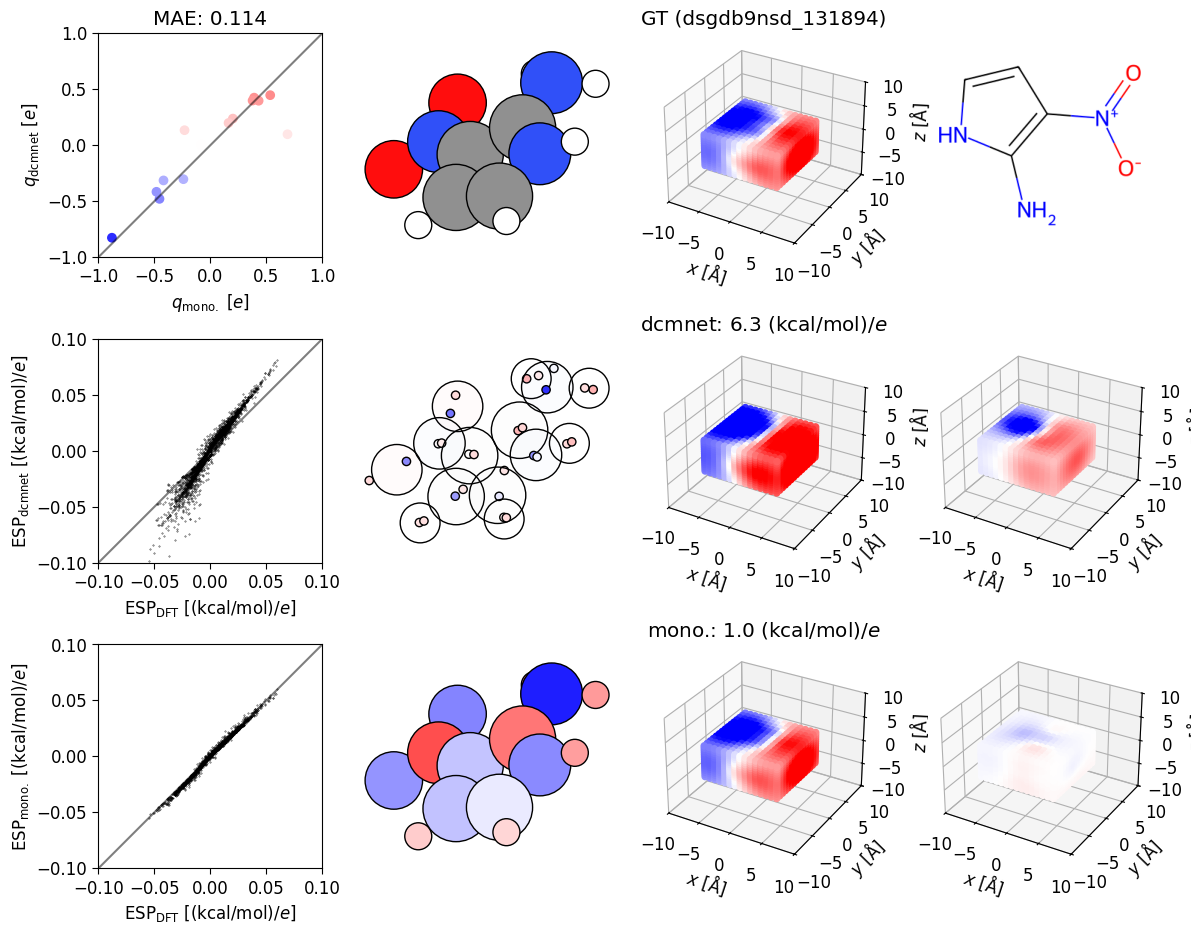

 10%|█████████▌                                                                                     | 1/10 [00:09<01:24,  9.41s/it]

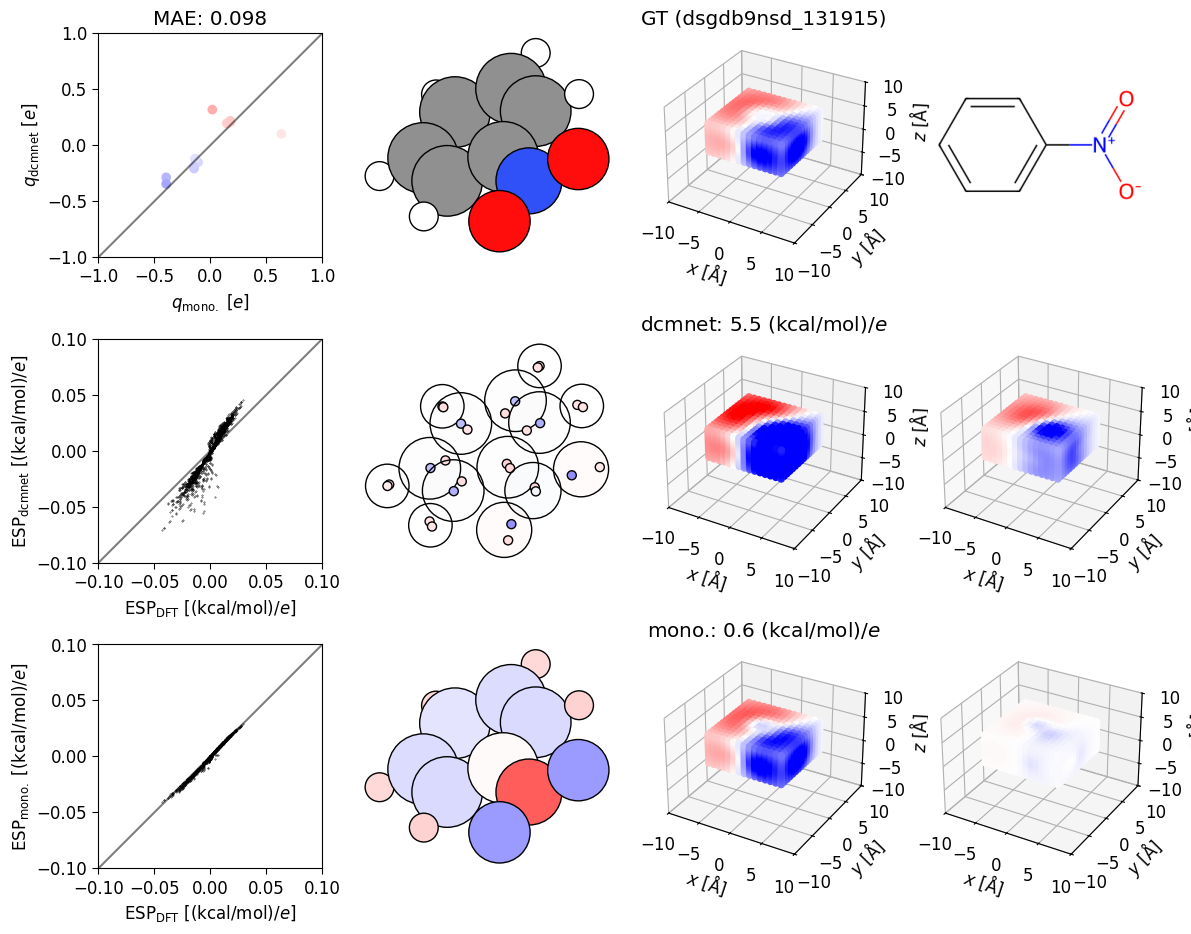

 20%|███████████████████                                                                            | 2/10 [00:18<01:13,  9.16s/it]

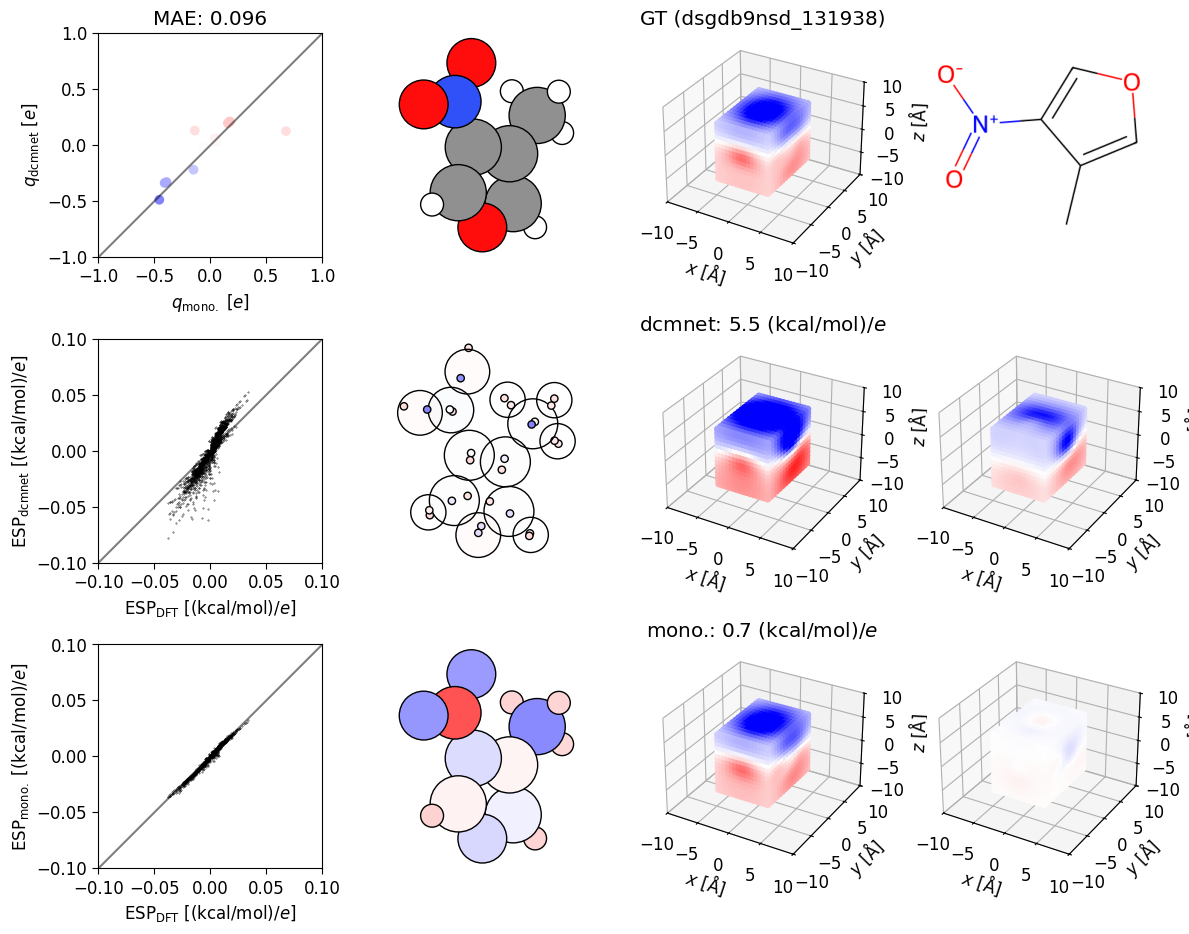

 30%|████████████████████████████▌                                                                  | 3/10 [00:27<01:04,  9.16s/it]

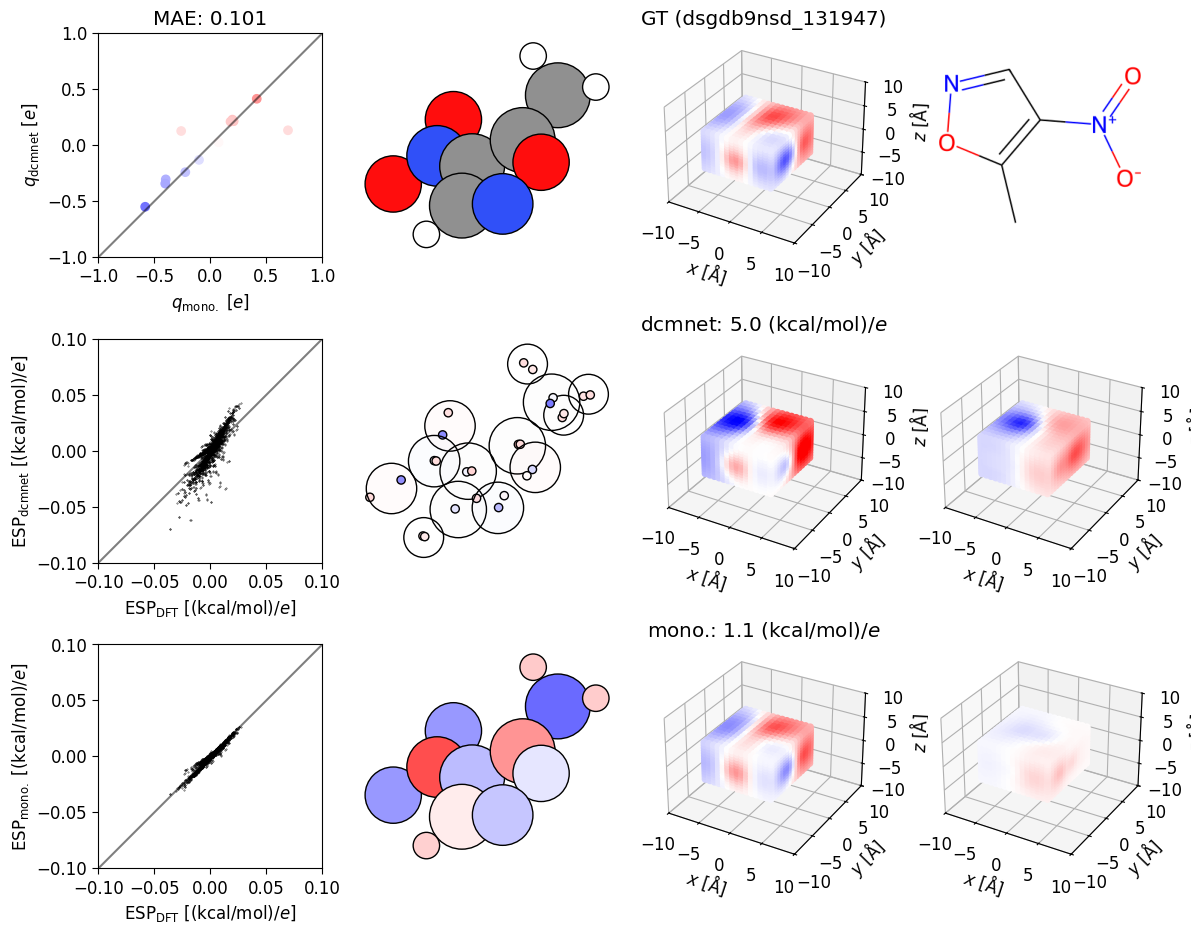

 40%|██████████████████████████████████████                                                         | 4/10 [00:37<00:56,  9.34s/it]

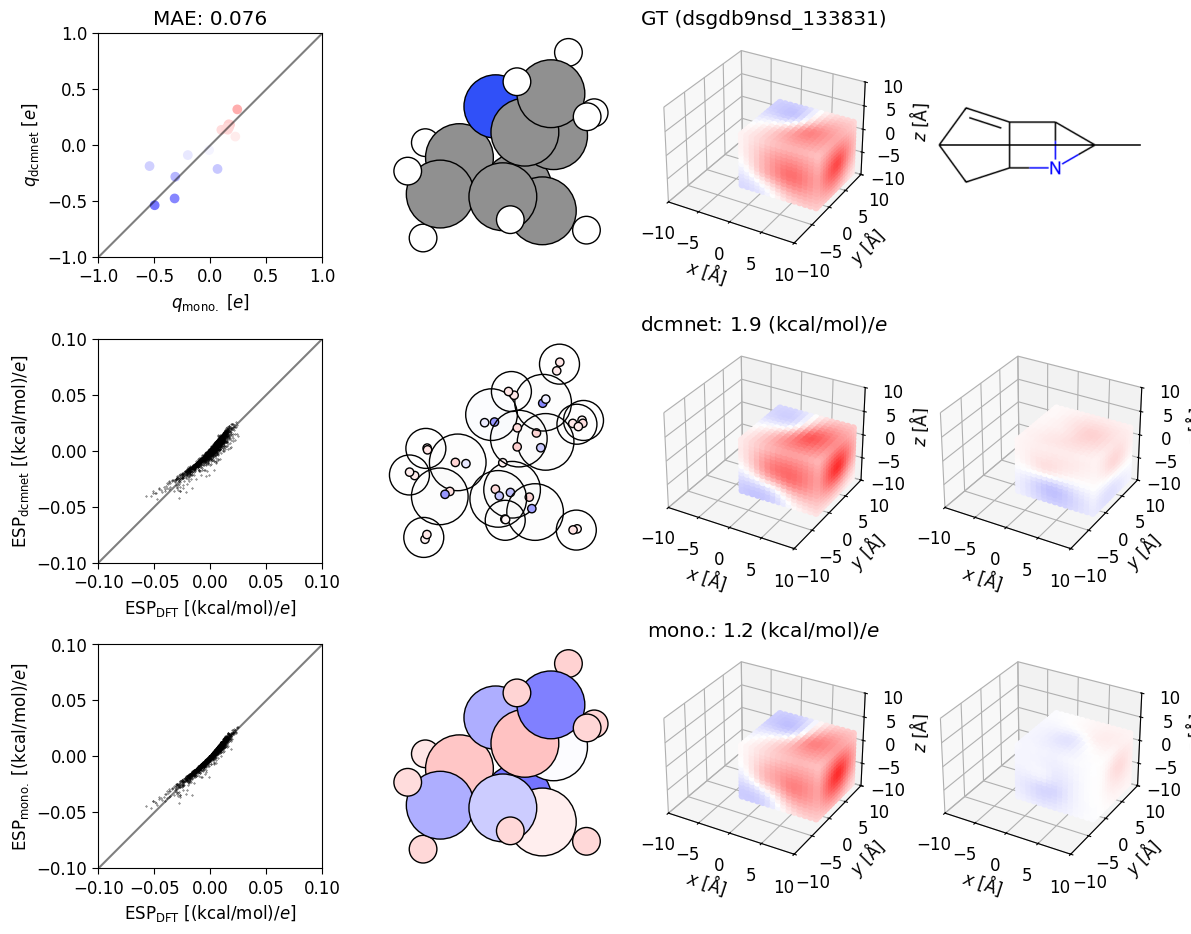

 50%|███████████████████████████████████████████████▌                                               | 5/10 [00:46<00:47,  9.41s/it]

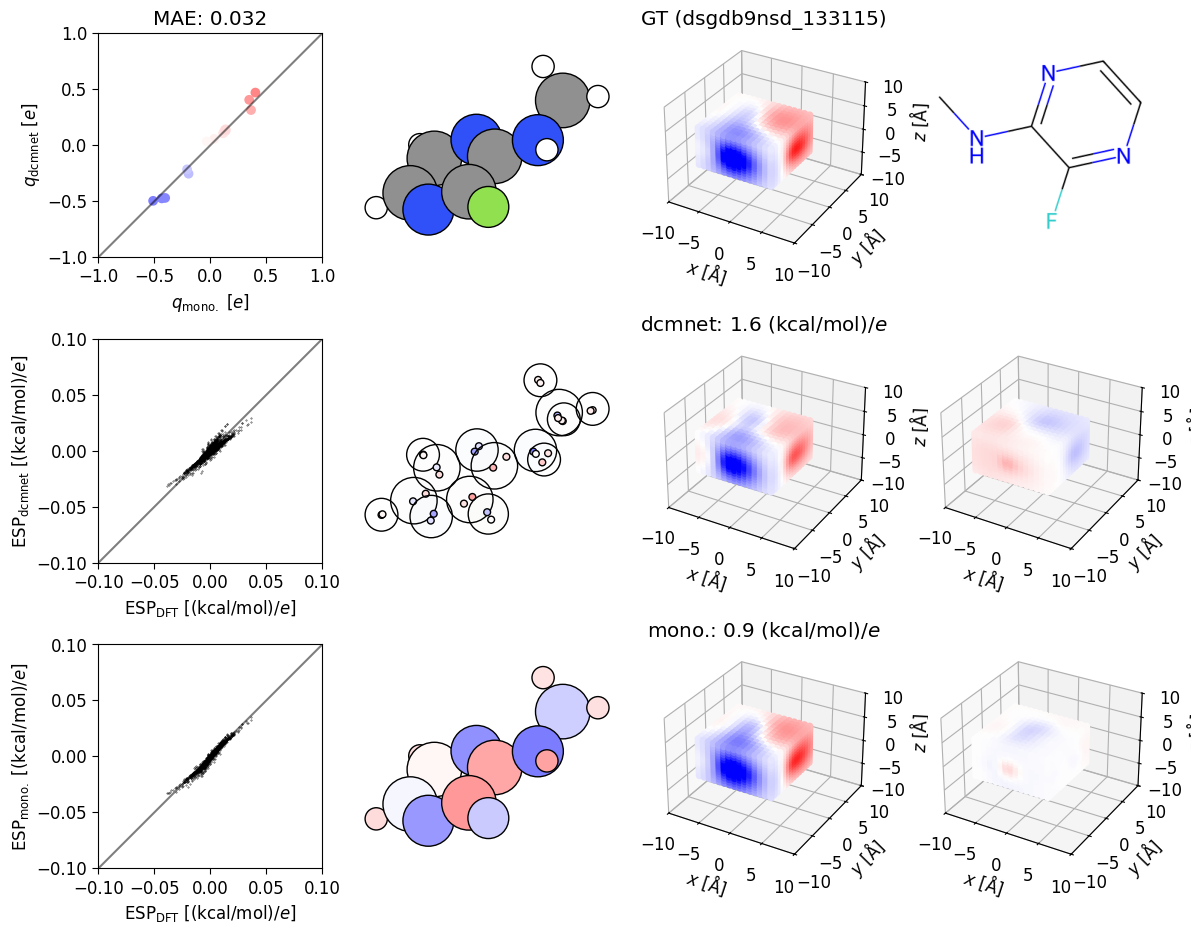

 60%|█████████████████████████████████████████████████████████                                      | 6/10 [00:55<00:37,  9.30s/it]

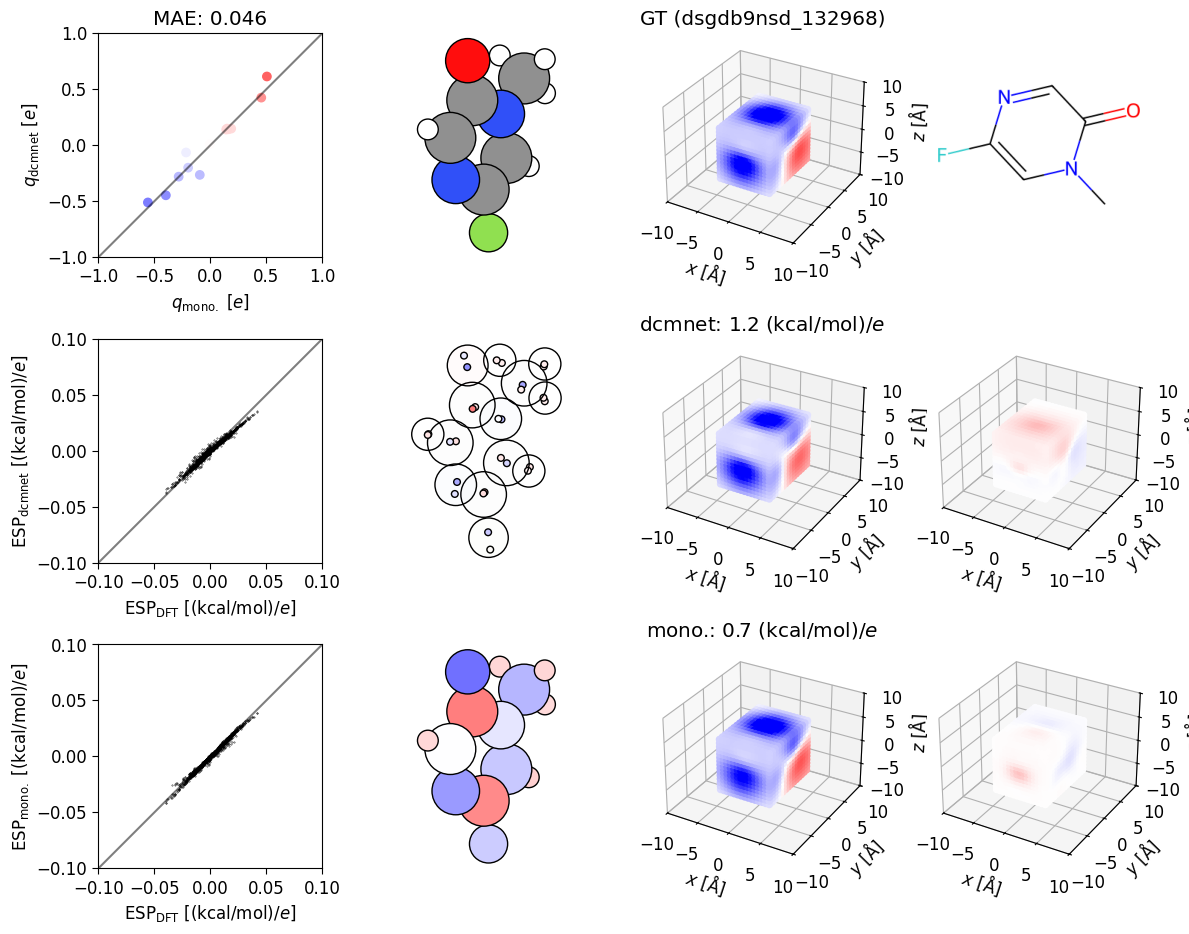

 70%|██████████████████████████████████████████████████████████████████▌                            | 7/10 [01:05<00:28,  9.52s/it]

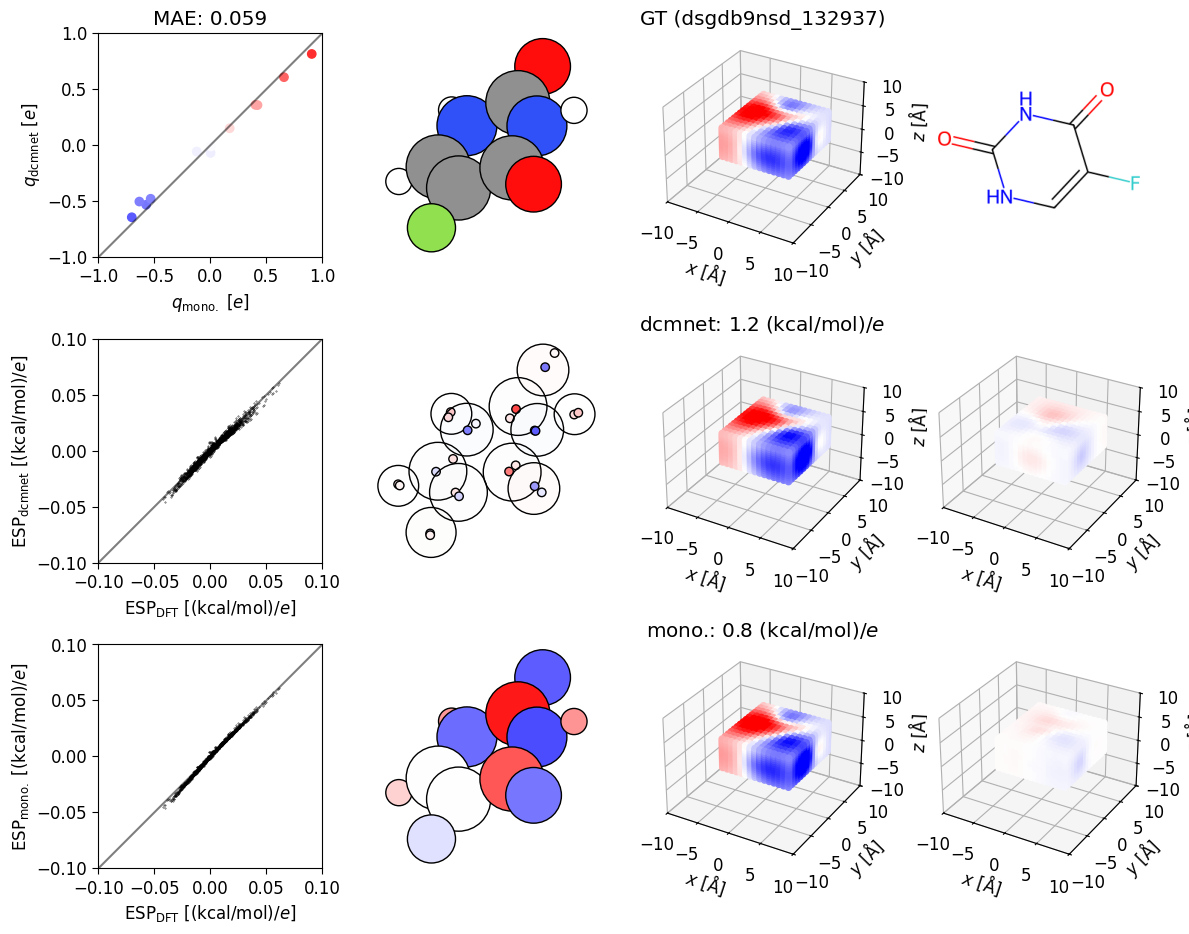

 80%|████████████████████████████████████████████████████████████████████████████                   | 8/10 [01:15<00:19,  9.56s/it]

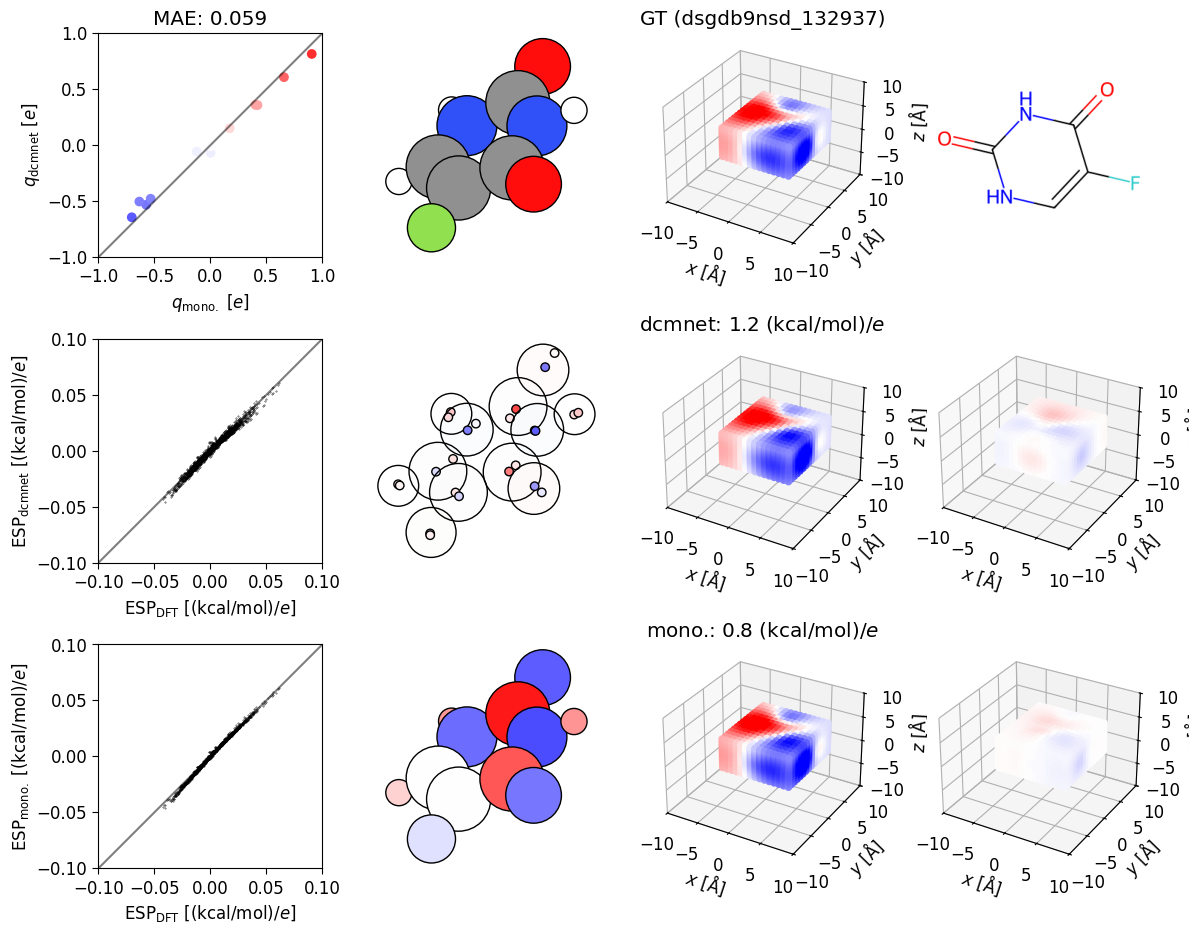

 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 9/10 [01:24<00:09,  9.55s/it]

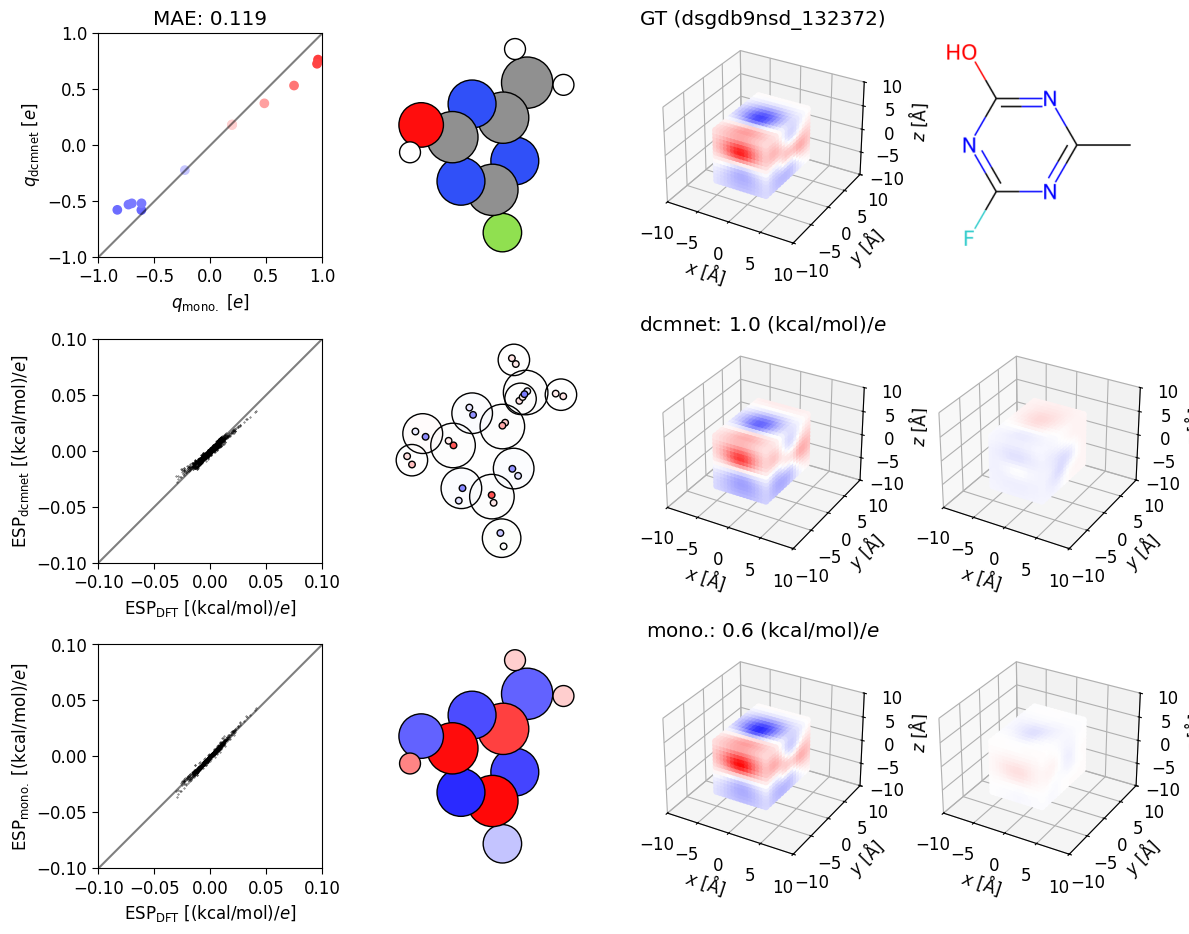

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.38s/it]


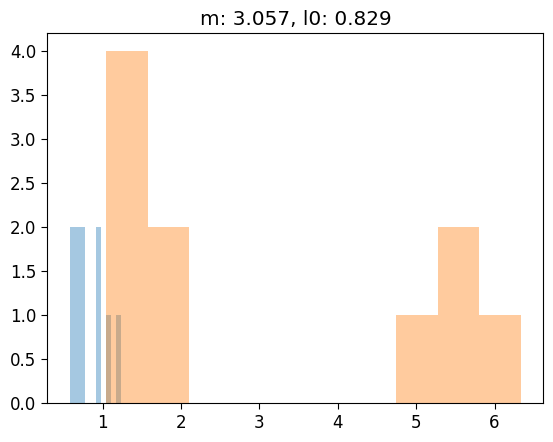

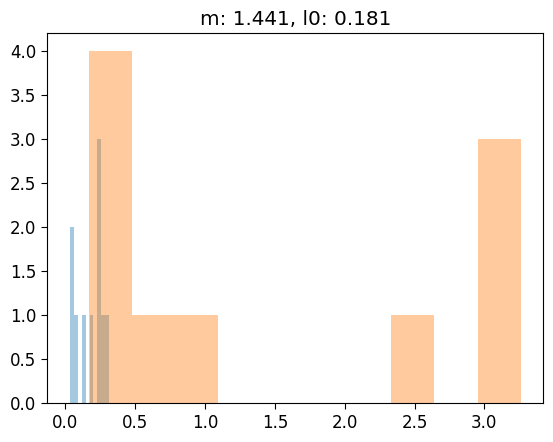

In [115]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(bad[:10]):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=True,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()